## Creating a STAC Collection for a Virtual Icechunk Store

There is a virtual icechunk store that is publicly available at: s3://nasa-waterinsight/virtual-zarr-store/NLDAS-3-icechunk/

This notebook goes through the current thinking for how you would set up a STAC collection that points to that virtual icechunk store and provides all the information a user needs to interact with the virtual zarr store programmatically or via a web UI. 

In [1]:
import json
import datetime

import icechunk
import pystac
import xstac
import zarr

import xarray as xr

Zarr can emit a lot of warnings about Numcodecs not being including in the Zarr version 3 specification yet -- let's suppress those.

In [2]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Numcodecs codecs are not in the Zarr version 3 specification*",
    category=UserWarning,
)

These are the PRs that need to land before you can open the virtual icechunk store with zarr directly:

- https://github.com/zarr-developers/zarr-python/pull/3369
- https://github.com/earth-mover/icechunk/pull/1161

Until then:

In [3]:
storage = icechunk.s3_storage(
    bucket="nasa-waterinsight",
    prefix="virtual-zarr-store/NLDAS-3-icechunk/",
    region="us-west-2",
    anonymous=True,
)

The `bucket` and `prefix` are from the icechunk href. The `anonymous=True` needs to come from somewhere else.

In [4]:
config = icechunk.RepositoryConfig.default()
config.set_virtual_chunk_container(
    icechunk.VirtualChunkContainer(
        "s3://nasa-waterinsight/NLDAS3/forcing/daily/",
        icechunk.s3_store(region="us-west-2")
    )
)
virtual_credentials = icechunk.containers_credentials(
    {
        "s3://nasa-waterinsight/NLDAS3/forcing/daily/": icechunk.s3_anonymous_credentials()
    }
)

Here we need the `href` for the internal storage bucket(s) (composed of `bucket` and `prefix`) and we need the `region` of that bucket. Then we need some way of providing credentials.

In [5]:
repo = icechunk.Repository.open(
    storage=storage,
    config=config,
    authorize_virtual_chunk_access=virtual_credentials,
)

session = repo.readonly_session(snapshot_id='YTNGFY4WY9189GEH1FNG')

Since icechunk manages versions (like git) we need some way of knowing which `branch`, `tag` or `snapshot_id` (similar to `commit`) to use. 

In [6]:
ds = xr.open_zarr(session.store, consolidated=False, zarr_format=3)

Last of all we need a way of specifying that we are looking at icechunk here as well as the standard fields: `consolidated`, `zarr_format` that are already included in the [STAC Zarr extension](https://github.com/stac-extensions/zarr).

Note that it is possible that these last two are not actually required. Xarray should know that for icechunk stores `consolidated` is always false and similarly xarray should be able to infer the zarr format from the store itself.

In [7]:
ds

<xarray.Dataset> Size: 51TB
Dimensions:   (time: 8399, lat: 6500, lon: 11700)
Coordinates:
  * time      (time) datetime64[ns] 67kB 2001-01-02 2001-01-03 ... 2024-01-01
  * lat       (lat) float64 52kB 7.005 7.015 7.025 7.035 ... 71.97 71.98 71.99
  * lon       (lon) float64 94kB -169.0 -169.0 -169.0 ... -52.03 -52.01 -52.0
Data variables:
    Tair_max  (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Wind_E    (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    PSurf     (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    SWdown    (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Qair      (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Tair_min  (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Rainf     (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Wind_N    (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    LWdown    (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Tair      (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
Attributes: (12/17)
    missing_value:          -9999.0
    time_definition:        daily
    shortname:              NLDAS_FOR0010_D_3.0
    title:                  NLDAS Forcing Data L4 Daily 0.01 x 0.01 degree V3...
    version:                3.0 beta
    institution:            NASA GSFC
    ...                     ...
    websites:               https://ldas.gsfc.nasa.gov/nldas/v3/ ; https://li...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  7.005000114440918
    SOUTH_WEST_CORNER_LON:  -168.9949951171875
    DX:                     0.009999999776482582
    DY:                     0.009999999776482582

Ok! We have the xarray dataset lazily opened by accessing only the virtual icechunk store! Now the goal is to create a STAC collection that describes that virtual icechunk store and contains all the information we need for accessing it (all the inputs to the functions above).

## Extract metadata for STAC collection

Now let's see how [xstac](https://github.com/stac-utils/xstac) can help us extract the variables and represent them using the [Datacube STAC Extension](https://github.com/stac-extensions/datacube/). 

<div class="alert alert-info">
    
This section takes inspiration from https://github.com/stac-utils/xstac/blob/main/examples/nasa-nex-gddp-cmip6/generate.py

</div>

We'll start with some of the hard-coded values that will need to be provided for any given dataset. As much as possible these should be lifted directly from the `xr.Dataset` attrs.

In [8]:
collection_id = "nldas-3"
description = (
    "NLDAS-3 provides a fine-scale (1 km) meteorological forcing (precipitation) in "
    "both retrospective and near real-time over North and Central America, including "
    "Alaska, Hawaii, and Puerto Rico, by leveraging high-quality gauge, satellite, "
    "and model datasets through advanced data assimilation methods. Read more: "
    "https://ldas.gsfc.nasa.gov/nldas/v3"
)
providers = [
    pystac.Provider(
        name="NLDAS",
        roles=["producer", "processor", "licensor"],
        url="https://ldas.gsfc.nasa.gov/nldas"
    )
]

I want to draw special attention to how we can use the [Storage STAC Extension](https://github.com/stac-extensions/storage) to capture that this particular bucket can be accessed anonymously. We can also capture the `region` within this blob.

In [9]:
storage_schemes = {
    "aws-s3-nasa-waterinsight": {
        "type": "aws-s3",
        "platform": "https://{bucket}.s3.{region}.amazonaws.com",
        "bucket": "nasa-waterinsight",
        "region": "us-west-2",
        "anonymous": True,
    }
}

Now let's configure some metadata that can be gotten from the `xr.Dataset` itself.

In [10]:
title = ds.attrs["title"]
extents = pystac.Extent(
    spatial=pystac.SpatialExtent(bboxes=[list(ds.rio.bounds())]),
    temporal=pystac.TemporalExtent(
        intervals=[
            datetime.datetime.fromisoformat(str(ds.time.min().values)),
            datetime.datetime.fromisoformat(str(ds.time.max().values))
        ]
    ),
)

Now that we have all those values set, create a `pystac.Collection`:

In [11]:
template = pystac.Collection(
    collection_id,
    description=description,
    extent=extents,
    extra_fields={"storage:schemes": storage_schemes, "item_assets": {}},
    providers=providers,
    title=title,
    stac_extensions=[
        "https://stac-extensions.github.io/storage/v2.0.0/schema.json",
    ]
)

Now that we have a preliminary version of the STAC Collection we can pass it off to `xstac` to pull out the variables and dims using the [Datacube STAC Extension](https://github.com/stac-extensions/datacube/).

In [12]:
collection = xstac.xarray_to_stac(
    ds,
    template,
    temporal_dimension="time",
    x_dimension="lon",
    y_dimension="lat",
    reference_system=4326,
    validate=False,
)

With that collection in hand we can create an asset that points to the virtual icechunk store and add it as a collection-level asset.

### Add collection-level assets

The main concern of the asset is how to access the data. So we need the asset to contain all the information we need to pass into icechunk functions when opening the virtual icechunk store.

In [13]:
snapshot_id = "YTNGFY4WY9189GEH1FNG"
virtual_href = "s3://nasa-waterinsight/virtual-zarr-store/NLDAS-3-icechunk/"

name = "nldas-3"
virtual_key = f"{name}@{snapshot_id}"
storage_ref = "aws-s3-nasa-waterinsight"

collection.add_asset(
    virtual_key,
    pystac.Asset(
        virtual_href,
        title="NLDAS-3 Virtual Zarr Store",
        media_type="application/vnd.zarr+icechunk",  # I made this up: discussion https://earthmover-community.slack.com/archives/C07NQCBSTB7/p1756918042834049
        roles=["data", "references", "virtual", "latest-version"],
        extra_fields={
            "zarr:consolidated": False,
            "zarr:zarr_format": 3,
            "icechunk:snapshot_id": snapshot_id,
            "storage:refs": [storage_ref],
        }
    )
)

 We also need to specify how to access the legacy files which potentially sit in their own bucket. We can use the [Virtual Assets STAC Extension](https://github.com/stac-extensions/virtual-assets) to capture that.

In [14]:
legacy_href = "s3://nasa-waterinsight/NLDAS3/forcing/daily/"
legacy_key = "nldas-3-legacy-bucket"

collection.add_asset(
    legacy_key,
    pystac.Asset(
        legacy_href,
        title="NLDAS-3 Legacy Bucket",
        media_type="application/x-netcdf",
        roles=["data"],
        extra_fields={
            "storage:refs": [storage_ref],
        }
    )
)

collection.assets[virtual_key].extra_fields["vrt:hrefs"] = [
    {
        "key": legacy_key,
        "href": f"https://raw.githubusercontent.com/NASA-IMPACT/dse-virtual-zarr-workshop/refs/heads/main/docs/examples/collection.json#/assets/{legacy_key}"
    },
]

We can also add information about how to render each variable. This uses the [Render STAC Extension](https://github.com/stac-extensions/render) and specifies how applications (for instance titiler) should represent each variable visually.

In [15]:
renders = {}
for k in ds:
    if k.startswith("LW"):
        colormap_name = "inferno"
    elif k.startswith("PS"):
        colormap_name = "viridis"
    elif k.startswith("Q"):
        colormap_name = "plasma"
    elif k.startswith("Rain"):
        colormap_name = "cfastie"
    elif k.startswith("SW"):
        colormap_name = "magma"
    elif k.startswith("T"):
        colormap_name = "RdYlBu_r"
    elif k.startswith("Wind"):
        colormap_name = "PuOr"
        
    renders[k] = {
        "title": ds[k].attrs["long_name"],
        "assets": ["nldas-3"],
        "resampling": "average",
        "colormap_name": colormap_name,
        "rescale": [[ds[k].attrs["vmin"], ds[k].attrs["vmax"]]],
        "backend": "xarray",
    }

collection.extra_fields["renders"] = renders

Last of all we will add the Zarr STAC Extension and the Render STAC Extension to the list of `stac_extensions`. We need to do this after adding the asset because they relies on there being assets in the collection. 

In [16]:
collection.stac_extensions = list(set(
    collection.stac_extensions + [
        "https://stac-extensions.github.io/render/v2.0.0/schema.json",
        "https://stac-extensions.github.io/virtual-assets/v1.0.0/schema.json",
        "https://stac-extensions.github.io/zarr/v1.1.0/schema.json",
        "https://stac-extensions.github.io/version/v1.2.0/schema.json",
    ]
))

Validate the collection

In [17]:
collection.validate()

['https://schemas.stacspec.org/v1.1.0/collection-spec/json-schema/collection.json',
 'https://stac-extensions.github.io/datacube/v2.2.0/schema.json',
 'https://stac-extensions.github.io/storage/v2.0.0/schema.json',
 'https://stac-extensions.github.io/version/v1.2.0/schema.json',
 'https://stac-extensions.github.io/zarr/v1.1.0/schema.json',
 'https://stac-extensions.github.io/virtual-assets/v1.0.0/schema.json',
 'https://stac-extensions.github.io/render/v2.0.0/schema.json']

Dump the collection to json

In [18]:
with open("collection.json", "w") as f:
    json.dump(collection.to_dict(), f, indent=2)

## Read the virtual icechunk using collection-level asset

Let's create a function that opens the virtual icechunk store as a virtual asset using only the STAC metadata. Don't worry too much about the function itself. Ideally this will end up living in xpystac (here is the issue for that: https://github.com/stac-utils/xpystac/issues/53) so you don't need to interact with it at all. The key takeaway is that the only input to this function is the virtual asset.

Now let's read the collection in from where we stored it in the json, find the latest version of the icechunk store, and lazily open it as an `xarray.Dataset`

In [19]:
collection = pystac.Collection.from_file("collection.json")

In [20]:
assets = collection.get_assets(role="latest-version")
assets

{'nldas-3@YTNGFY4WY9189GEH1FNG': <Asset href=s3://nasa-waterinsight/virtual-zarr-store/NLDAS-3-icechunk/>}

In [21]:
asset = next(iter(assets.values()))

Make sure you can actually access underlying data:

In [22]:
%%time

cape_rain = ds.Rainf.sel(
    time="2023-07-16",
    lat=slice(41.48, 42.10),
    lon=slice(-70.84, -69.77)
).compute()

CPU times: user 1.05 s, sys: 423 ms, total: 1.47 s
Wall time: 5.2 s


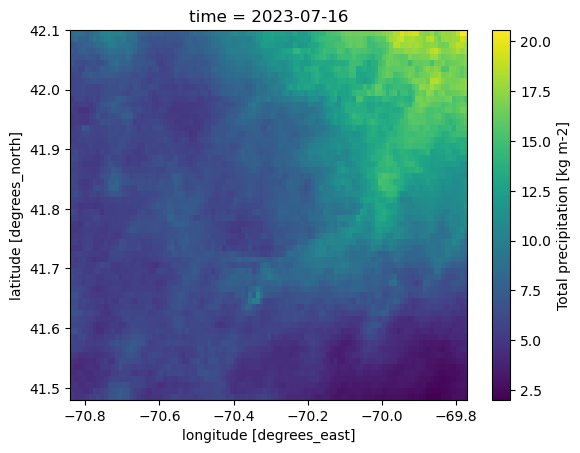

In [23]:
cape_rain.plot()

In [24]:
#import hvplot.xarray

In [25]:
#cape_rain.hvplot(x='lon', y='lat', geo=True, rasterize=True, tiles='OSM', cmap='turbo', alpha=0.7)